In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score,train_test_split, cross_val_predict
from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer, recall_score, accuracy_score, precision_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

#Libraries for visualizing trees
from sklearn.tree import export_graphviz 
from six import StringIO
from IPython.display import Image  
from sklearn import tree
import pydotplus

import time as time

In [3]:
# Reading Data 
data = pd.read_excel("df.xlsx")
data = data.drop('id', axis =1)
data.diagnosis = data.diagnosis.eq('M').mul(1)
data
y = data.diagnosis
X = data.drop("diagnosis", axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 45, stratify = y)

In [4]:
#Initial Naive Decision Tree
model = DecisionTreeClassifier(random_state=1, max_depth=3) 
naivetree = model.fit(X_train, y_train)
#tree.plot_tree(naivetree)

In [5]:
importance = list(naivetree.feature_importances_)
name = list(naivetree.feature_names_in_)
df = pd.DataFrame()
df['Feature Name'] = name
df['Feature Importance'] = importance
#list(df.sort_values(by='Feature Importance', ascending=False)['Feature Name'])

Accuracy:  89.47368421052632
ROC-AUC:  0.9351851851851851
Recall:  0.7857142857142857


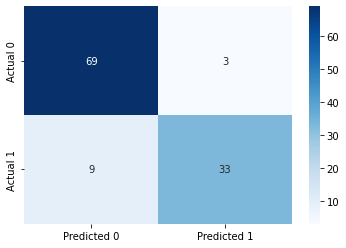

In [6]:
#Analysis
y_pred = naivetree.predict(X_test)
print("Accuracy: ",accuracy_score(y_pred, y_test)*100)  

#Computing the ROC-AUC
y_pred_prob = model.predict_proba(X_test)[:,1]
fpr, tpr, auc_thresholds = roc_curve(y_test, y_pred_prob)
print("ROC-AUC: ",auc(fpr, tpr))# AUC of ROC

#Computing recall (false negatice)
print("Recall: ", recall_score(y_test, y_pred))

#Confusion matrix
cm = pd.DataFrame(confusion_matrix(y_test, y_pred), columns=['Predicted 0', 'Predicted 1'], 
            index = ['Actual 0', 'Actual 1'])
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g');

In [44]:
# Tuned Decision Tree
param_grid = {    
    'max_depth': (1,6),
    'max_leaf_nodes': range(2,21),
    'max_features': range(1,30)
}

start_time = time.time()
skf = StratifiedKFold(n_splits=2)#The folds are made by preserving the percentage of samples for each class.

#Minimizing FNR is equivalent to maximizing recall
grid_search = GridSearchCV(DecisionTreeClassifier(random_state=1), param_grid, scoring=['recall'], 
                           refit="recall", cv=skf, n_jobs=-1, verbose = True)
grid_search.fit(X_train, y_train)

# make the predictions
y_pred = grid_search.predict(X_test)

print('Train accuracy : %.3f'%grid_search.best_estimator_.score(X_train, y_train))
print('Best recall Through Grid Search : %.3f'%grid_search.best_score_)

print('Best params for recall')
print(grid_search.best_params_)

print("Time taken =", round((time.time() - start_time)), "seconds")

Fitting 2 folds for each of 1102 candidates, totalling 2204 fits
Train accuracy : 0.952
Best recall Through Grid Search : 0.929
Best params for recall
{'max_depth': 6, 'max_features': 7, 'max_leaf_nodes': 5}
Time taken = 7 seconds


In [45]:
# Tuned Model
truemodel = DecisionTreeClassifier(random_state=1, max_depth = 6, max_leaf_nodes=5, max_features=7).fit(X_train, y_train)

Accuracy:  92.98245614035088
Recall:  0.9285714285714286


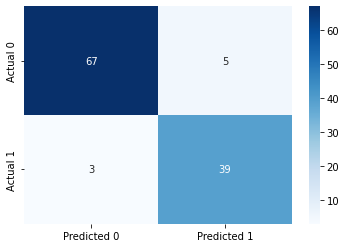

In [46]:
# Analysis
y_pred = truemodel.predict(X_test)
print("Accuracy: ",accuracy_score(y_pred, y_test)*100)  

#Computing recall (false negative)
print("Recall: ", recall_score(y_test, y_pred))

#Confusion matrix
cm = pd.DataFrame(confusion_matrix(y_test, y_pred), columns=['Predicted 0', 'Predicted 1'], 
            index = ['Actual 0', 'Actual 1'])
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g');

In [47]:
# Feature Importance, Output Hidden
importance = list(truemodel.feature_importances_)
name = list(truemodel.feature_names_in_)
df = pd.DataFrame()
df['Feature Name'] = name
df['Feature Importance'] = importance
#list(df.sort_values(by='Feature Importance', ascending=False)['Feature Name'])

[Text(0.5, 0.875, 'X[27] <= 0.145\ngini = 0.468\nsamples = 455\nvalue = [285, 170]'),
 Text(0.25, 0.625, 'X[20] <= 16.805\ngini = 0.186\nsamples = 309\nvalue = [277, 32]'),
 Text(0.125, 0.375, 'gini = 0.062\nsamples = 279\nvalue = [270, 9]'),
 Text(0.375, 0.375, 'gini = 0.358\nsamples = 30\nvalue = [7, 23]'),
 Text(0.75, 0.625, 'X[15] <= 0.073\ngini = 0.104\nsamples = 146\nvalue = [8, 138]'),
 Text(0.625, 0.375, 'X[13] <= 18.5\ngini = 0.057\nsamples = 137\nvalue = [4, 133]'),
 Text(0.5, 0.125, 'gini = 0.375\nsamples = 4\nvalue = [3, 1]'),
 Text(0.75, 0.125, 'gini = 0.015\nsamples = 133\nvalue = [1, 132]'),
 Text(0.875, 0.375, 'gini = 0.494\nsamples = 9\nvalue = [4, 5]')]

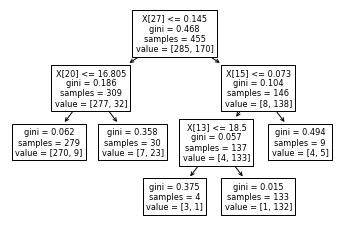

In [48]:
# Picture of new model
tree.plot_tree(truemodel)

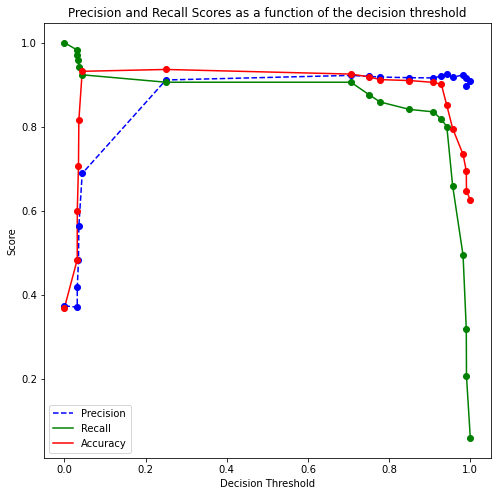

In [49]:
# Tuning decision threshold
from sklearn.model_selection import cross_val_score, cross_val_predict

cross_val_ypred = cross_val_predict(truemodel, X_train, y_train, cv = 5, method = 'predict_proba')

p, r, thresholds = precision_recall_curve(y_train, cross_val_ypred[:,1])
acc = np.ndarray(shape = (len(thresholds),))
i = 0
for th in thresholds:
    y_pred = cross_val_ypred[:,1] > th
    y_pred = y_pred.astype(int)
    acc[i] = accuracy_score(y_pred, y_train)
    i = i + 1
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.figure(figsize=(8, 8))
    plt.title("Precision and Recall Scores as a function of the decision threshold")
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.plot(thresholds, acc, "r-", label="Accuracy")
    plt.plot(thresholds, precisions[:-1], "o", color = 'blue')
    plt.plot(thresholds, recalls[:-1], "o", color = 'green')
    plt.plot(thresholds, acc, "o", color = 'red')
    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    plt.legend(loc='best')
    plt.legend()
plot_precision_recall_vs_threshold(p, r, thresholds)

In [50]:
# Finding desired threshold
all_thresholds = np.concatenate([thresholds.reshape(-1,1), acc.reshape(-1,1), r[:-1].reshape(-1,1)], axis = 1)
# Ensures Recall more than 90
greater = all_thresholds[(all_thresholds[:,2]>0.9) & (all_thresholds[:,1]>0.9),:]
greater[0]

array([0.04366812, 0.93186813, 0.92352941])

Accuracy:  92.98245614035088
Recall:  0.9285714285714286


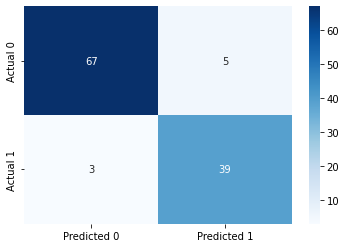

In [51]:
# Analyzing results with new decision threshold
desired_threshold = 0.5
y_pred_prob = truemodel.predict_proba(X_test)[:,1]

y_pred2 = y_pred_prob > desired_threshold
y_pred2 = y_pred2.astype(int)

#Computing the accuracy
print("Accuracy: ",accuracy_score(y_pred2, y_test)*100)  

#Computing the recall
print("Recall: ", recall_score(y_test, y_pred2))

#Confusion matrix
cm = pd.DataFrame(confusion_matrix(y_test, y_pred2), 
                  columns=['Predicted 0', 'Predicted 1'], index = ['Actual 0', 'Actual 1'])
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g');